<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/waves/CRLB_for_Two_Mode_Phase_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cramer-Rao Bound for Two-mode Phase Retrieval
*Timothy Schulz and David Brady*

## Python packages and some functions
Python packages: 

In [ ]:
import math
import numpy as np
import numpy.random as rand
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la 
import scipy.sparse as sp

## Cramer-Rao Bound for amplitude and phase
For two-mode phase retrieval, the two modes are represented as $A_1$ and $A_2 e^{j \theta}$, where $\theta$ is the phase difference between the modes. The modes are transformed by the $M \times 2$ linear sampling matrix ${\bf H}$ to provide the intermediate signal $\underline{y}$:

\begin{equation}
\underline{y} = {\bf H}
\left[
  \begin{array}{c}
  A_1 \\ A_2^{j\theta}
  \end{array}
\right].
\end{equation}

To assure that the sampling is passive, both of the eigenvalues for ${\bf H}^\dagger {\bf H}$ must be less than or equal to 1. The observable signal, then, is the intensity for $\underline{y}$:

\begin{equation}
I_m = |y_m|^2.
\end{equation}

When the observed data are limited by photon noise, the Fisher information for the unobserved parameters is evaluated as
\begin{equation}
J_{\lambda, \gamma} = \sum_{m=1}^M 
\frac{\partial I_m}{\partial \lambda}
\frac{\partial I_m}{\partial \gamma}
\frac{1}{I_m}
\end{equation}
where $\lambda$ and $\gamma$ correspond to pairs of the parameters $(A_1, A_2, \theta)$. For example, the Fisher information for $A_1$ and $\theta$ is
\begin{equation}
J_{A_1, \theta} = \sum_{m=1}^M 
\frac{\partial I_m}{\partial A_1}
\frac{\partial I_m}{\partial \theta}
\frac{1}{I_m}
\end{equation}
The Fisher-information matrix is
\begin{equation}
{\bf J} = 
\left[
  \begin{array}{ccc}
  J_{A_1,A_1} & J_{A_1,A_2} & J_{A_1,\theta} \\
  J_{A_2,A_1} & J_{A_2,A_2} & J_{A_2,\theta} \\
  J_{\theta,A_1} & J_{\theta,A_2} & J_{\theta,\theta}
  \end{array}
\right],
\end{equation}  
and the Cramer-Rao lower bound matrix is
\begin{equation}
{\bf C} = {\bf J}^{-1}.
\end{equation}

In [ ]:

# Version: 2020_04_30 7:14 PM

def twoPointPhaseRetrievalCRLB(A1, A2, theta, H):
#
# twoPointPhaseRetrievalCRLB:
#   Python function to evaluate the Cramer-Rao Lower Bound for the
#   phase-retrieval problem with a specific observation matrix H.
#
# Usage:
#   CRLB = twoPointPhaseRetrievalCRLB(A1, A2, theta, H);
#
# Inputs:
#      A1: KxN array of amplitudes for the first element in the signal
#      A2: KxN array of amplitudes for the second element in the signal
#   theta: KxN array of phases for the signal
#       H: Mx2 observation matrix 
#
# Outputs:
#      CRLB.A1: KxN array of the CRLB for the amplitudes specified in A1
#      CRLB.A2: KxN array of the CRLB for the amplitudes specified in A2
#   CRLB.theta: KxN array of the CRLB for the phases specified in theta
#
  # verify that the sampling system is passive
  (w, v) = la.eig(H.conjugate().T.dot(H))
  if w.real.max() > 1.0001:
    print('Sampling systems is not passive!')
    return -1

  # determine the number of samples
  M    = H.shape[0]

  # extract the sampling coefficients
  h1   = H[:,0]
  h2   = H[:,1]
  h1sq = np.power(np.abs(h1),2)
  h2sq = np.power(np.abs(h2),2)
  h12  = np.abs(h1*h2)
  phi  = np.angle(h2*np.conjugate(h1))

  # initialize the Fisher information elements
  # (because of symmetry, J12 = J21, etc.)
  J11 = np.zeros(np.shape(A1))
  J12 = np.zeros(np.shape(A1))
  J1t = np.zeros(np.shape(A1))
  J22 = np.zeros(np.shape(A1))
  J2t = np.zeros(np.shape(A1))
  Jtt = np.zeros(np.shape(A1))  

  # evaluate the Fisher information elements
  for m in range(0,M):
    I    = np.power(A1,2)*h1sq[m] + np.power(A2,2)*h2sq[m] + \
           2*A1*A2*h12[m]*np.cos(theta + phi[m])
    dIk1 = 2*(A2*np.cos(theta + phi[m])*h12[m] + A1*h1sq[m])
    dIk2 = 2*(A1*np.cos(theta + phi[m])*h12[m] + A2*h2sq[m])
    dIkt = -2*A1*A2*h12[m]*np.sin(theta + phi[m])
    J11  = J11 + dIk1*dIk1/I
    J12  = J12 + dIk1*dIk2/I
    J1t  = J1t + dIk1*dIkt/I
    J22  = J22 + dIk2*dIk2/I
    J2t  = J2t + dIk2*dIkt/I
    Jtt  = Jtt + dIkt*dIkt/I

  # determine the CRLB elements for the parameters
  detJ = -(np.power(J1t,2)*J22) + 2*J12*J1t*J2t - \
         J11*np.power(J2t,2) - np.power(J12,2)*Jtt + J11*J22*Jtt
  class CRLB:
    A1    = (-np.power(J2t,2) + J22*Jtt)/detJ         
    A2    = (-np.power(J1t,2) + J11*Jtt)/detJ 
    theta = (-np.power(J12,2) + J11*J22)/detJ
  return CRLB

# Example: 6 element sampling

Text(0.5, 1.0, 'CRLB for the estimation of $\\theta$')

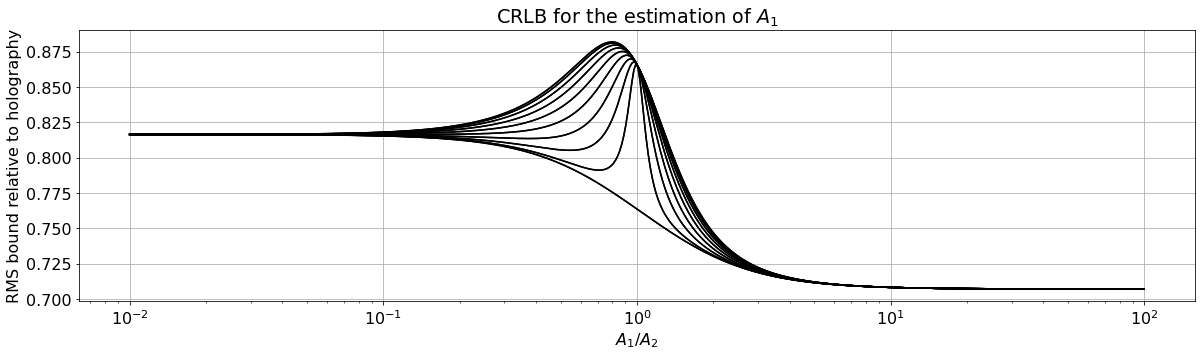

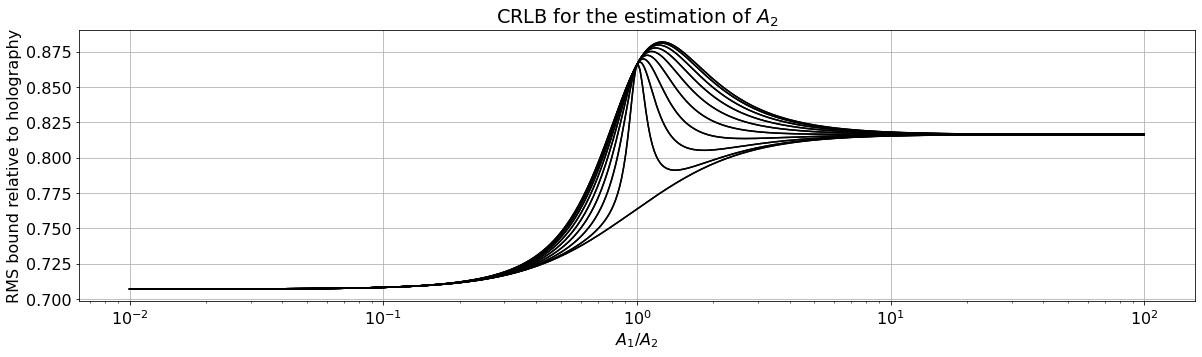

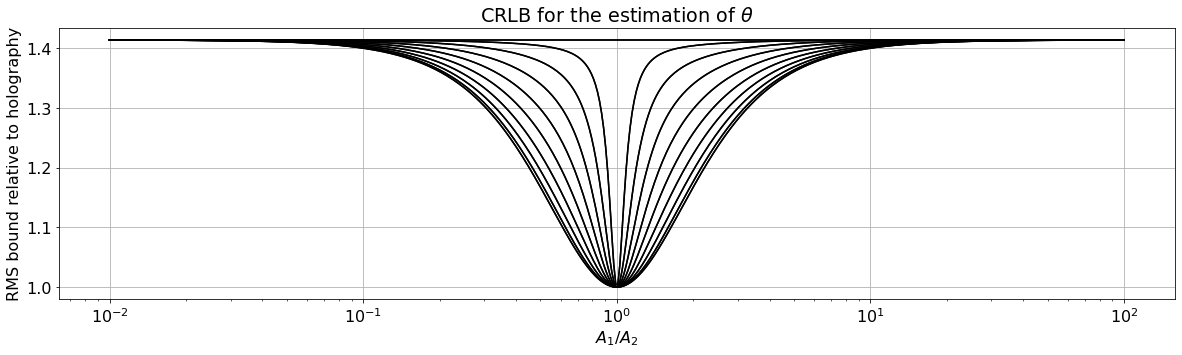

In [ ]:
#
# sampling matrix
#
intenR=.5; # ratio of signal in pure intensity measurement
iSam=np.sqrt(1-intenR);
pSam=np.sqrt(intenR)/2;
H=np.array([[iSam,0], [0, iSam],[pSam, pSam],[pSam, -pSam],[pSam, 1j*pSam],[pSam, -1j*pSam]] )
#
# parameter values
#
abar         = 1
rho          = np.logspace(-2, 2, 500)
theta        = np.linspace(-math.pi, math.pi, 20)
[Rho, Theta] = np.meshgrid(rho, theta)
# 
# evaluate CRLBs
#
CRLB = twoPointPhaseRetrievalCRLB(abar*np.sqrt(Rho), \
                                  abar/np.sqrt(Rho), \
                                  Theta, H)

#
# plot the results
#
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [20,5]
plt.figure(1)
_ = plt.semilogx(rho, np.sqrt(CRLB.A1/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $A_1$')
plt.figure(2)
_ = plt.semilogx(rho, np.sqrt(CRLB.A2/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $A_2$')
plt.figure(3)
_ = plt.semilogx(rho, np.sqrt(CRLB.theta/((Rho + 1/Rho)/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $\theta$')

## Example: Fourier Sampling
This example demonstrates the problem with tradiational Fourier sampling for phase retrieval with a two-element support constraint.

Text(0.5, 1.0, 'CRLB for the estimation of $\\theta$')

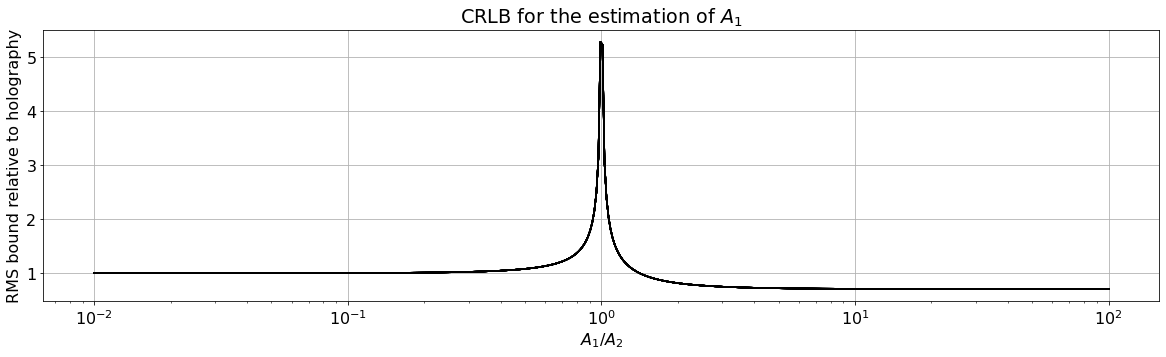

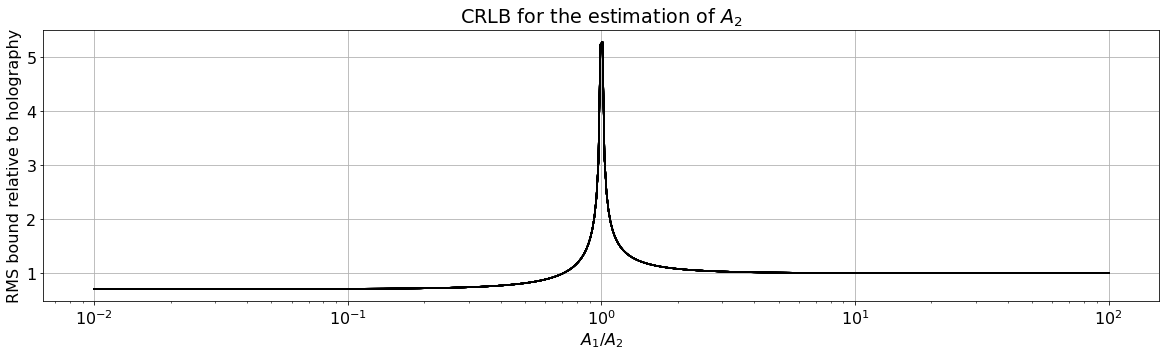

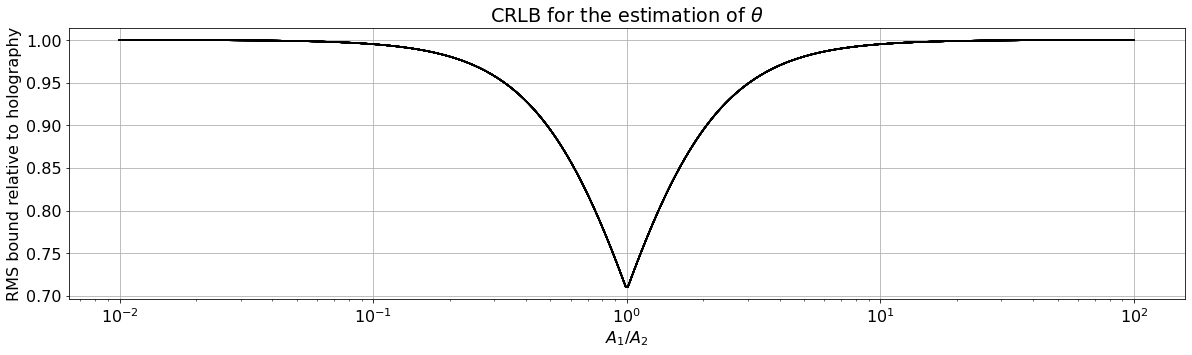

In [ ]:
#
# sampling matrix
#
M     = 1000;
m     = np.arange(0,M)
f1    = 0; f2 = f1 + 1;
h1    = np.exp(-1j*2*np.pi*f1*m/M)/np.sqrt(M)
h2    = np.exp(-1j*2*np.pi*f2*m/M)/np.sqrt(M)
H     = np.column_stack((h1, h2))
#
# parameter values
#
abar         = 1
rho          = np.logspace(-2, 2, 500)
theta        = np.linspace(-math.pi, math.pi, 20)
[Rho, Theta] = np.meshgrid(rho, theta)
# 
# evaluate CRLBs
#
CRLB = twoPointPhaseRetrievalCRLB(abar*np.sqrt(Rho), \
                                  abar/np.sqrt(Rho), \
                                  Theta, H)

#
# plot the results
#
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [20,5]
plt.figure(1)
_ = plt.semilogx(rho, np.sqrt(CRLB.A1/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $A_1$')
plt.figure(2)
_ = plt.semilogx(rho, np.sqrt(CRLB.A2/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $A_2$')
plt.figure(3)
_ = plt.semilogx(rho, np.sqrt(CRLB.theta/((Rho + 1/Rho)/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $\theta$')

## General Sampling
In this section, you can evaluate the CRLBs for an arbitrary sampling scheme as specified by the $M \times 2$ sampling matrix ${\bf H}$. The only constraint on the sampling matrix is that both eigenvalues for ${\bf H}^\dagger {\bf H}$ be less than or equal to 1. 

[2, 6, 27, 19, 21, 25]


Text(0.5, 1.0, 'CRLB for the estimation of $\\theta$')

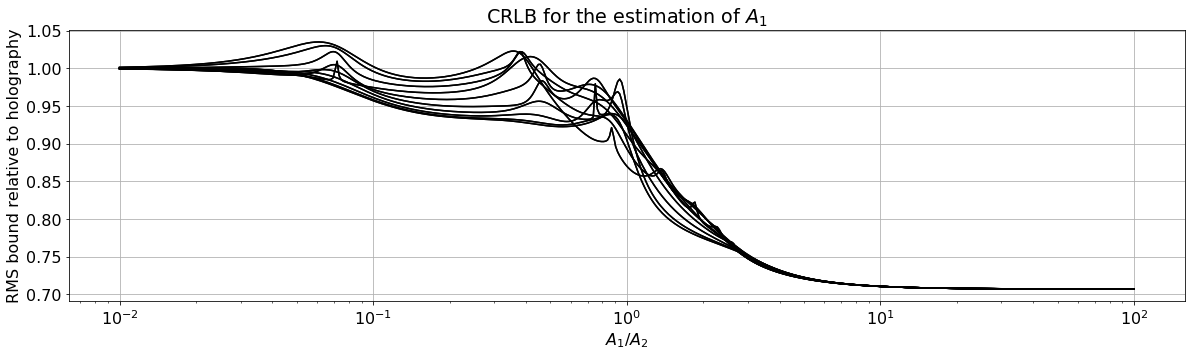

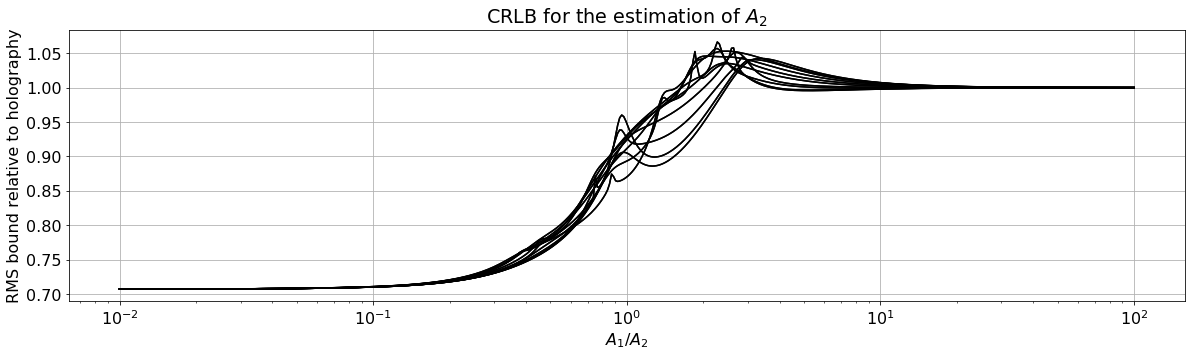

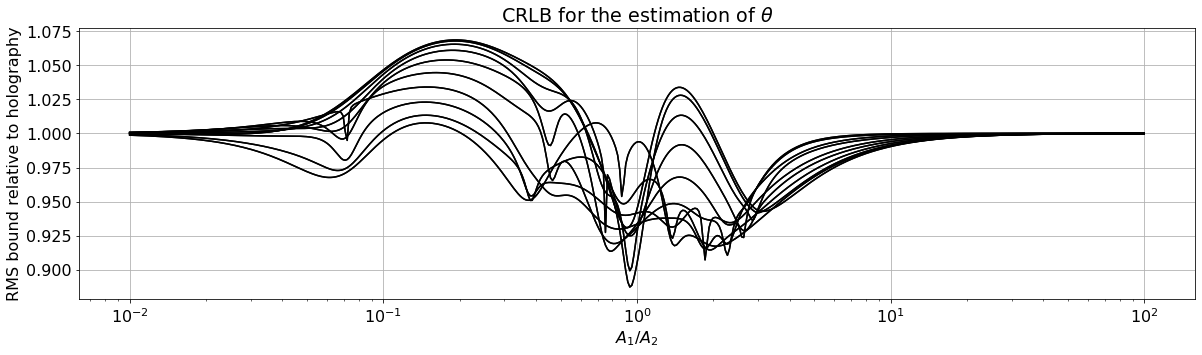

In [ ]:
#
# Specify the sampling matrix here:
#
M     = 50;
m     = np.arange(0,M)/M
f1    = 1 
f2    = 3
nu    = 23
h1    = np.cos(2*np.pi*f1*m)
h2    = np.cos(2*np.pi*f2*m)*np.exp(1j*2*np.pi*nu*m)
h1    = h1/np.sqrt(np.power(np.abs(h1),2).sum())
h2    = h2/np.sqrt(np.power(np.abs(h2),2).sum())
H     = np.column_stack((h1, h2))

#
# parameter values
#
abar         = 1
rho          = np.logspace(-2, 2, 500)
theta        = np.linspace(-math.pi, math.pi, 20)
[Rho, Theta] = np.meshgrid(rho, theta)
# 
# evaluate CRLBs
#
CRLB = twoPointPhaseRetrievalCRLB(abar*np.sqrt(Rho), \
                                  abar/np.sqrt(Rho), \
                                  Theta, H)
#
# plot the results
#
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [20,5]
plt.figure(1)
_ = plt.semilogx(rho, np.sqrt(CRLB.A1/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $A_1$')
plt.figure(2)
_ = plt.semilogx(rho, np.sqrt(CRLB.A2/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $A_2$')
plt.figure(3)
_ = plt.semilogx(rho, np.sqrt(CRLB.theta/((Rho + 1/Rho)/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $\theta$')

question: how is it possible for the above curve to be asymetric about $A_1/A_2 =1$?

## Small sampling matrix

Text(0.5, 1.0, 'CRLB for the estimation of $\\theta$')

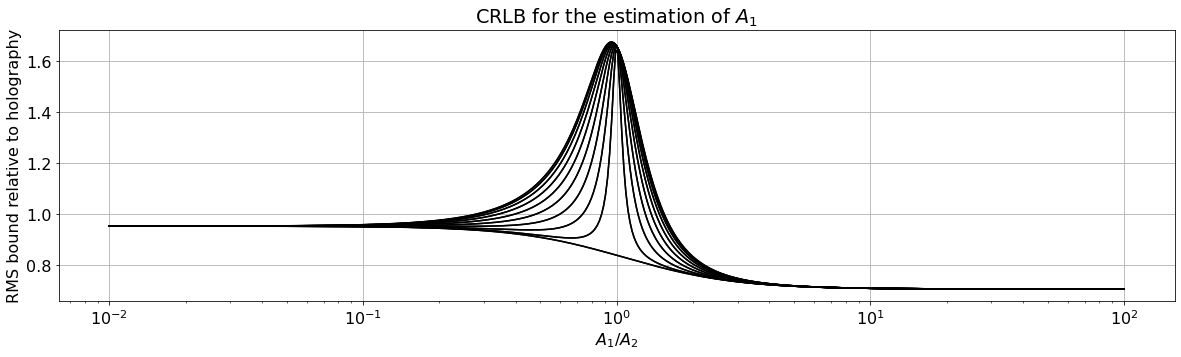

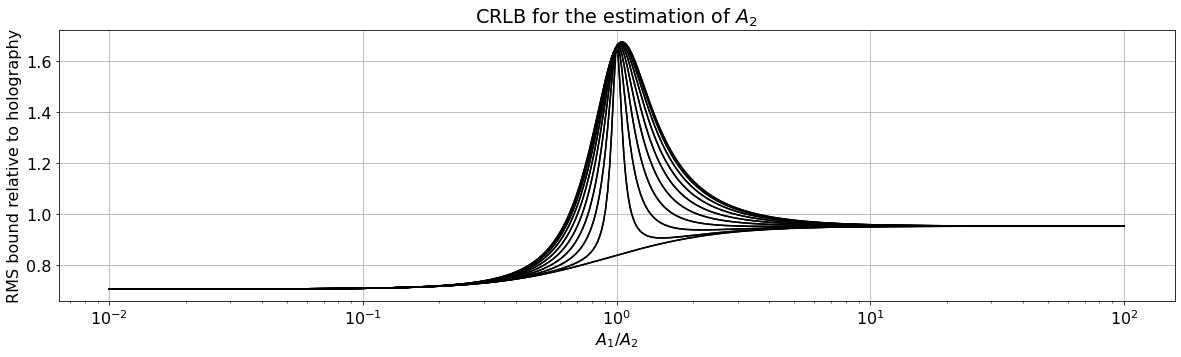

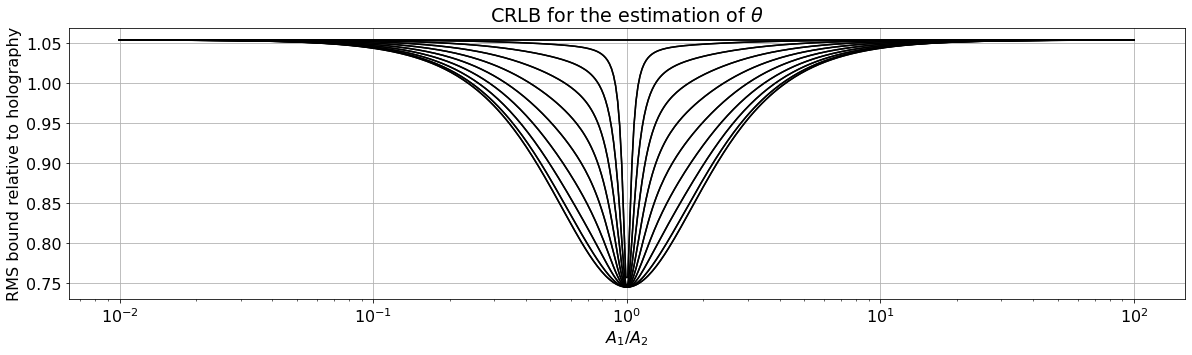

In [ ]:
#
# Specify the sampling matrix here:
#
intenR=.9; # ratio of signal in pure intensity measurement
iSam=np.sqrt(1-intenR);
pSam=np.sqrt(intenR)/2;
H=np.array([[iSam,0], [0, iSam],[pSam, pSam],[pSam, -pSam],[pSam, 1j*pSam],[pSam, -1j*pSam]] )

#
# parameter values
#
abar         = 1
rho          = np.logspace(-2, 2, 500)
theta        = np.linspace(-math.pi, math.pi, 20)
[Rho, Theta] = np.meshgrid(rho, theta)
# 
# evaluate CRLBs
#
CRLB = twoPointPhaseRetrievalCRLB(abar*np.sqrt(Rho), \
                                  abar/np.sqrt(Rho), \
                                  Theta, H)
#
# plot the results
#
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [20,5]
plt.figure(1)
_ = plt.semilogx(rho, np.sqrt(CRLB.A1/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $A_1$')
plt.figure(2)
_ = plt.semilogx(rho, np.sqrt(CRLB.A2/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $A_2$')
plt.figure(3)
_ = plt.semilogx(rho, np.sqrt(CRLB.theta/((Rho + 1/Rho)/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $\theta$')

## Example: Unbalanced Fourier Sampling
This example demonstrates the problem with tradiational Fourier sampling for phase retrieval with a two-element support constraint.

Text(0.5, 1.0, 'CRLB for the estimation of $\\theta$')

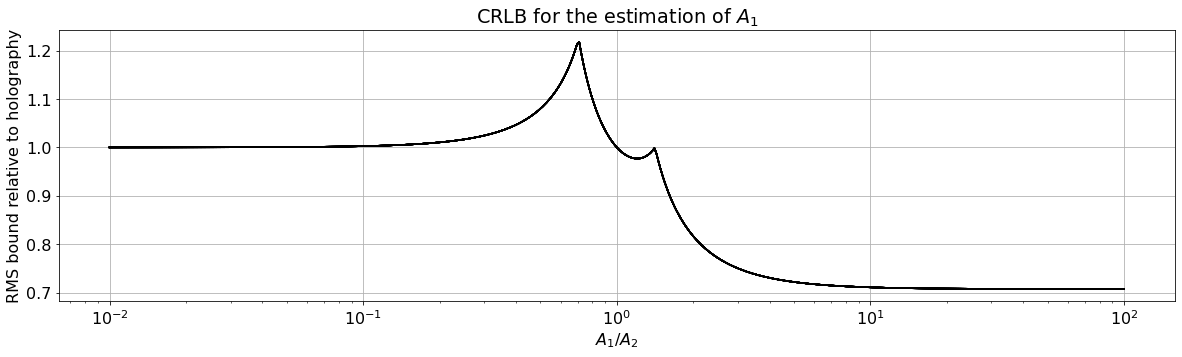

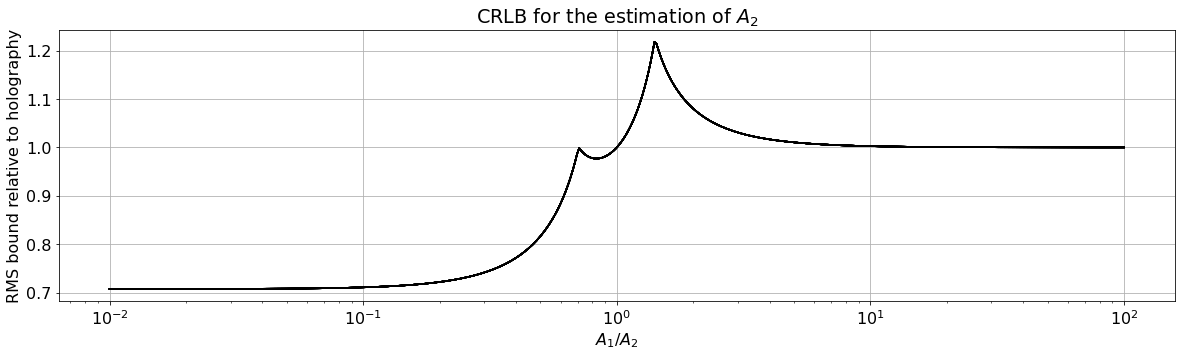

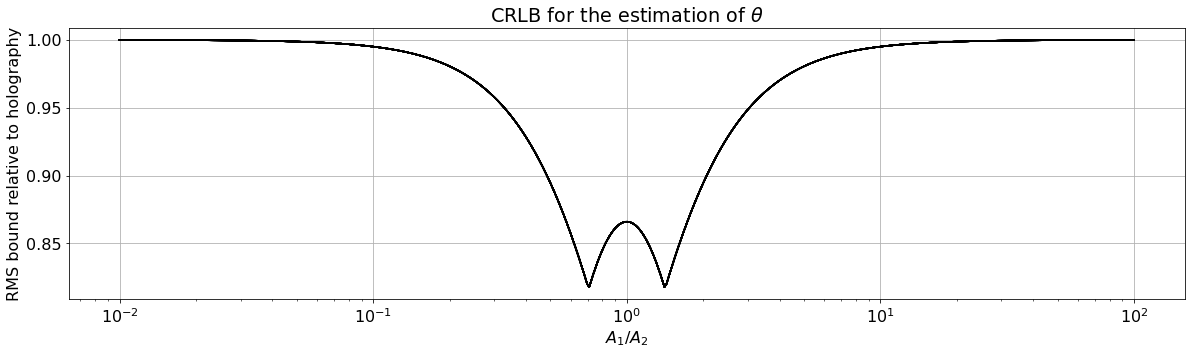

In [ ]:
#
# sampling matrix
#
M     = 1000;
m     = np.arange(0,M)
f1    = 0; f2 = f1 + 1;
h1    = np.sqrt(2/3)*np.exp(-1j*2*np.pi*f1*m/M)/np.sqrt(M)
h2    = np.sqrt(1/3)*np.exp(-1j*2*np.pi*f2*m/M)/np.sqrt(M)
H     = np.column_stack((h1, h2))
M     = 1000;
m     = np.arange(0,M)
f1    = 0; f2 = f1 + 1;
h1    = np.sqrt(1/3)*np.exp(-1j*2*np.pi*f1*m/M)/np.sqrt(M)
h2    = np.sqrt(2/3)*np.exp(-1j*2*np.pi*f2*m/M)/np.sqrt(M)
H1     = np.column_stack((h1, h2))
H     = np.row_stack((H, H1))
#
# parameter values
#
abar         = 1
rho          = np.logspace(-2, 2, 500)
theta        = np.linspace(-math.pi, math.pi, 20)
[Rho, Theta] = np.meshgrid(rho, theta)
# 
# evaluate CRLBs
#
CRLB = twoPointPhaseRetrievalCRLB(abar*np.sqrt(Rho), \
                                  abar/np.sqrt(Rho), \
                                  Theta, H)

#
# plot the results
#
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [20,5]
plt.figure(1)
_ = plt.semilogx(rho, np.sqrt(CRLB.A1/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $A_1$')
plt.figure(2)
_ = plt.semilogx(rho, np.sqrt(CRLB.A2/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $A_2$')
plt.figure(3)
_ = plt.semilogx(rho, np.sqrt(CRLB.theta/((Rho + 1/Rho)/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $\theta$')

## Modal Sampling

Measurements on a two mode system may typically be made using a two port beam splitter. The two modes are input, if the transformation between the two input modes and the output modes is unitary, no power is lost. The modal transformation for this case is
\begin{equation}
{\bf H}= 
\left[
  \begin{array}{cc}
  \cos\theta & e^{i\psi}\sin\theta\\
  -e^{-i\psi}\sin\theta&\cos\theta \\
  \end{array}
\right].
\end{equation}
Here $\theta$ and $\phi$ are in the range $[-\pi, \pi]$. We may consider the question of how much information we capture we measure the "entire" $\theta, \psi$ plane or if we measure points in the plane adaptively. 



Text(0.5, 1.0, 'CRLB for the estimation of $\\theta$')

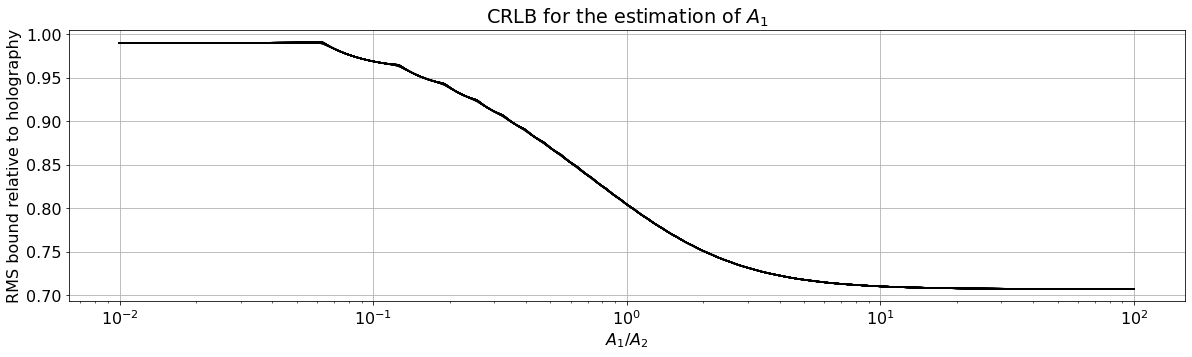

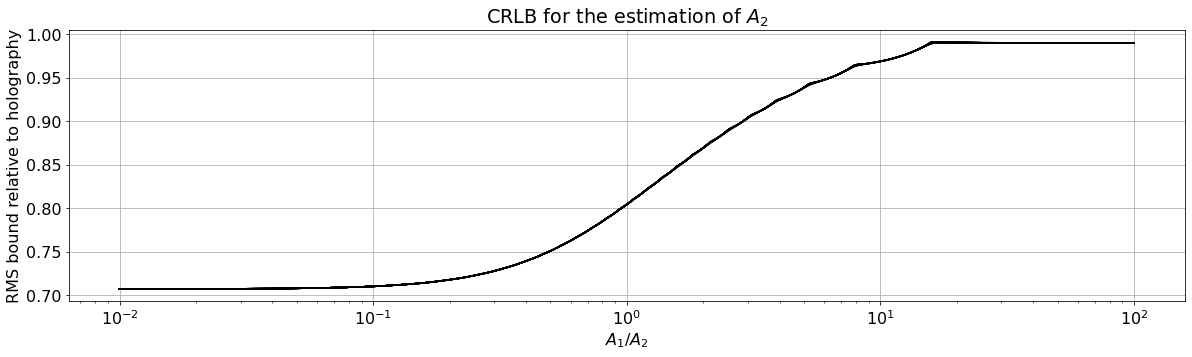

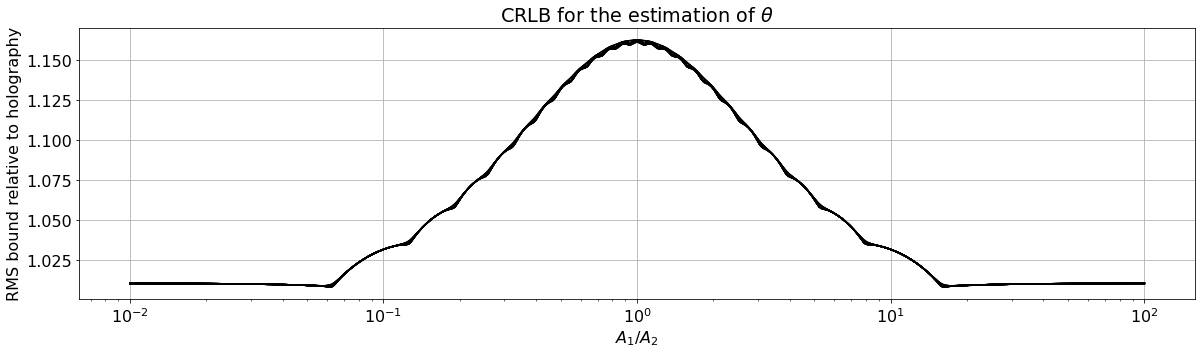

In [ ]:
#
# Specify the sampling matrix here:
#
#
# Specify the sampling matrix here:
#
Mt     = 50;
Mp     =50;
Hp=np.complex64([[1,0],[0,1]]);
for pip in range(Mt-1):
  for pop in range(Mp):
    hl=[[np.cos(2*np.pi*(pip+1)/Mt), np.exp(1j*2*np.pi*pop/Mp)*np.sin(2*np.pi*(pip+1)/Mt)], [ -np.exp(1j*2*np.pi*pop/Mp)*np.sin(2*np.pi*(pip+1)/Mt), np.cos(2*np.pi*(pip+1)/Mt)]];
    Hp=np.vstack((Hp,hl))
H=Hp/np.sqrt(np.sum(np.power(np.abs(Hp),2),0))
#
# parameter values
#
abar         = 1
rho          = np.logspace(-2, 2, 500)
theta        = np.linspace(-math.pi, math.pi, 20)
[Rho, Theta] = np.meshgrid(rho, theta)
# 
# evaluate CRLBs
#
CRLB = twoPointPhaseRetrievalCRLB(abar*np.sqrt(Rho), \
                                  abar/np.sqrt(Rho), \
                                  Theta, H)
#
# plot the results
#
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [20,5]
plt.figure(1)
_ = plt.semilogx(rho, np.sqrt(CRLB.A1/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $A_1$')
plt.figure(2)
_ = plt.semilogx(rho, np.sqrt(CRLB.A2/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $A_2$')
plt.figure(3)
_ = plt.semilogx(rho, np.sqrt(CRLB.theta/((Rho + 1/Rho)/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $\theta$')

Let's try emphasizing phase sampling over amplitude variation.

Text(0.5, 1.0, 'CRLB for the estimation of $\\theta$')

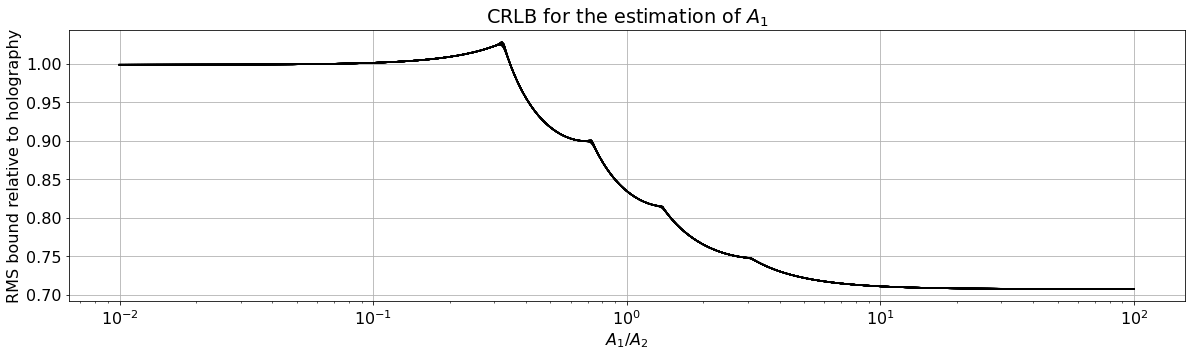

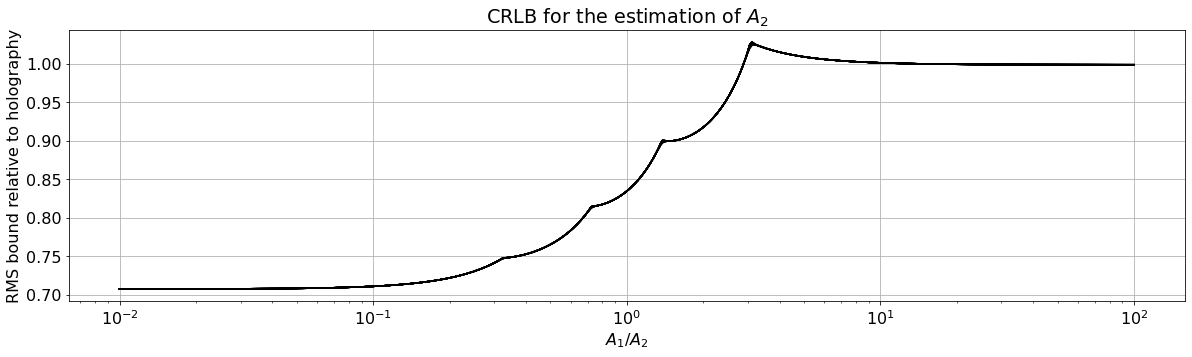

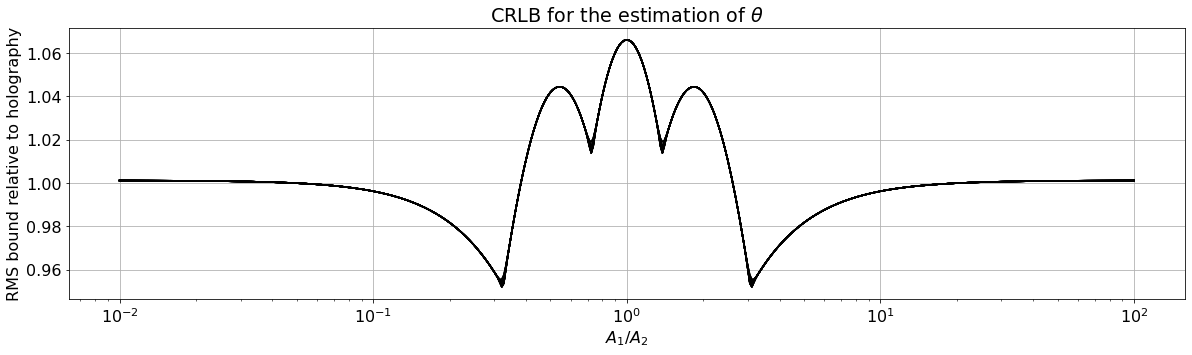

In [ ]:
#
# Specify the sampling matrix here:
#
#
# Specify the sampling matrix here:
#
Mt     = 5;
Mp     =100;
Hp=np.complex64([[1,0],[0,1]]);
for pip in range(Mt-1):
  for pop in range(Mp):
    hl=[[np.cos(2*np.pi*(pip+1)/Mt), np.exp(1j*2*np.pi*pop/Mp)*np.sin(2*np.pi*(pip+1)/Mt)], [ -np.exp(1j*2*np.pi*pop/Mp)*np.sin(2*np.pi*(pip+1)/Mt), np.cos(2*np.pi*(pip+1)/Mt)]];
    Hp=np.vstack((Hp,hl))
H=Hp/np.sqrt(np.sum(np.power(np.abs(Hp),2),0))
#
# parameter values
#
abar         = 1
rho          = np.logspace(-2, 2, 500)
theta        = np.linspace(-math.pi, math.pi, 20)
[Rho, Theta] = np.meshgrid(rho, theta)
# 
# evaluate CRLBs
#
CRLB = twoPointPhaseRetrievalCRLB(abar*np.sqrt(Rho), \
                                  abar/np.sqrt(Rho), \
                                  Theta, H)
#
# plot the results
#
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [20,5]
plt.figure(1)
_ = plt.semilogx(rho, np.sqrt(CRLB.A1/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $A_1$')
plt.figure(2)
_ = plt.semilogx(rho, np.sqrt(CRLB.A2/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $A_2$')
plt.figure(3)
_ = plt.semilogx(rho, np.sqrt(CRLB.theta/((Rho + 1/Rho)/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $\theta$')

Here we try sampling more heavily in the range where a1 and a2 are both non zero

Text(0.5, 1.0, 'CRLB for the estimation of $\\theta$')

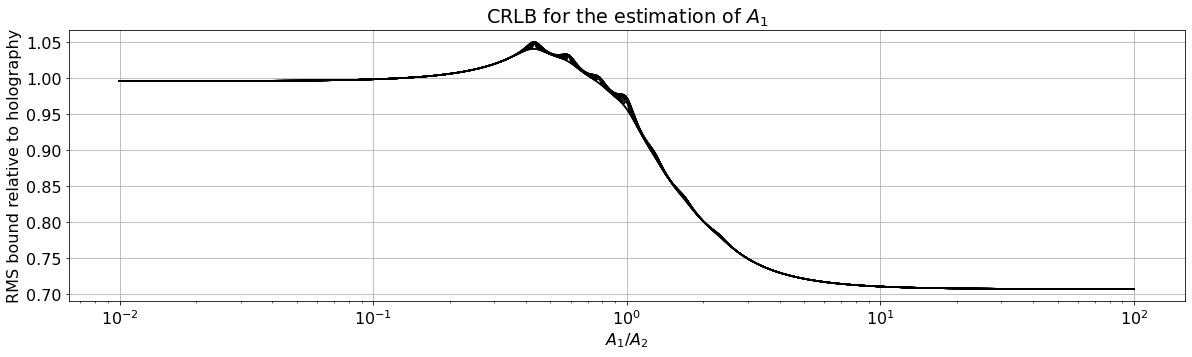

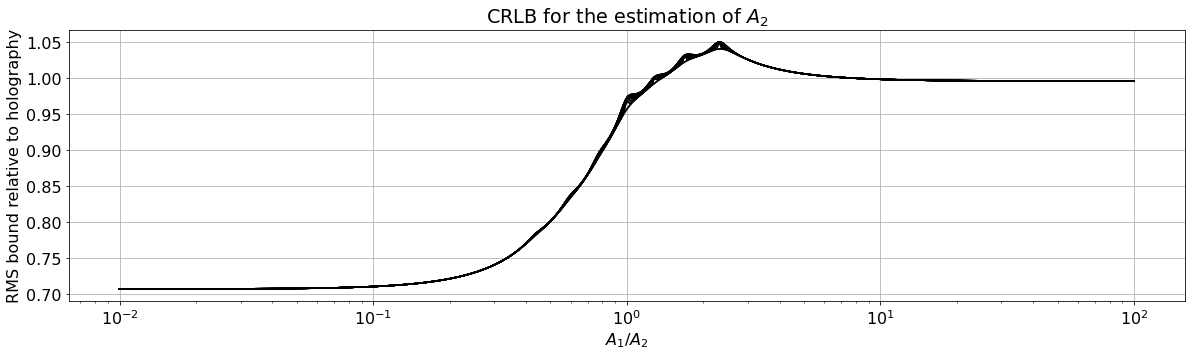

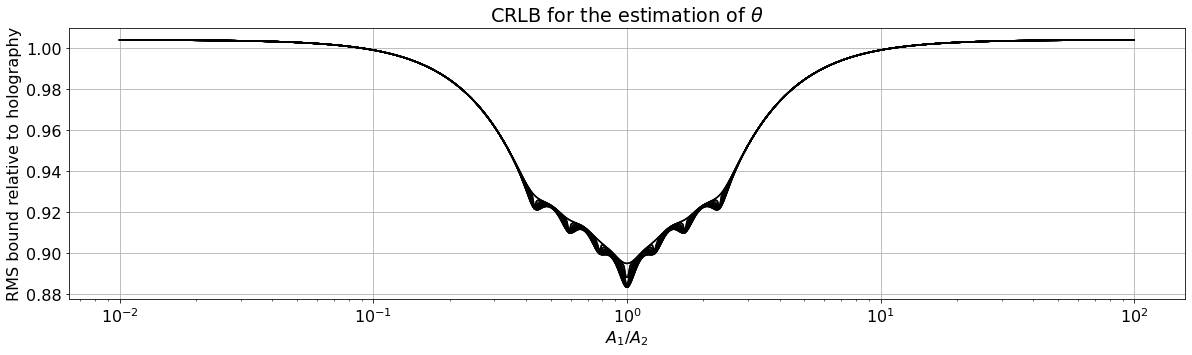

In [ ]:
#
# Specify the sampling matrix here:
#
#
# Specify the sampling matrix here:
#
Mt     = 5;
Mp     =30;
Hp=np.complex64([[1,0],[0,1]]);
for pip in range(Mt-1):
  for pop in range(Mp):
    hl=[[np.cos(2*np.pi*(.125 +.1*(pip/Mt))), np.exp(1j*2*np.pi*pop/Mp)*np.sin(2*np.pi*(.125 +.1*(pip/Mt)))],\
        [ -np.exp(1j*2*np.pih1    = np.exp(-1j*2*np.pi*f1*m/M)/np.sqrt(M)
h2    = np.exp(-1j*2*np.pi*f2*m/M)/np.sqrt(M)
H     = np.column_stack((h1, h2))*pop/Mp)*np.sin(2*np.pi*(.125 +.1*(pip/Mt))), np.cos(2*np.pi*(.125 +.1*(pip/Mt)))]];
    Hp=np.vstack((Hp,hl))
H=Hp/np.sqrt(np.sum(np.power(np.abs(Hp),2),0))
#
# parameter values
#
abar         = 1
rho          = np.logspace(-2, 2, 500)
theta        = np.linspace(-math.pi, math.pi, 20)
[Rho, Theta] = np.meshgrid(rho, theta)
# 
# evaluate CRLBs
#
CRLB = twoPointPhaseRetrievalCRLB(abar*np.sqrt(Rho), \
                                  abar/np.sqrt(Rho), \
                                  Theta, H)
#
# plot the results
#
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [20,5]
plt.figure(1)
_ = plt.semilogx(rho, np.sqrt(CRLB.A1/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $A_1$')
plt.figure(2)
_ = plt.semilogx(rho, np.sqrt(CRLB.A2/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $A_2$')
plt.figure(3)
_ = plt.semilogx(rho, np.sqrt(CRLB.theta/((Rho + 1/Rho)/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $\theta$')

what if we measure the ampitude separately and then the phase. This is essentially Fourier sampling with an additional measurement for amplitude. 

Text(0.5, 1.0, 'CRLB for the estimation of $\\theta$')

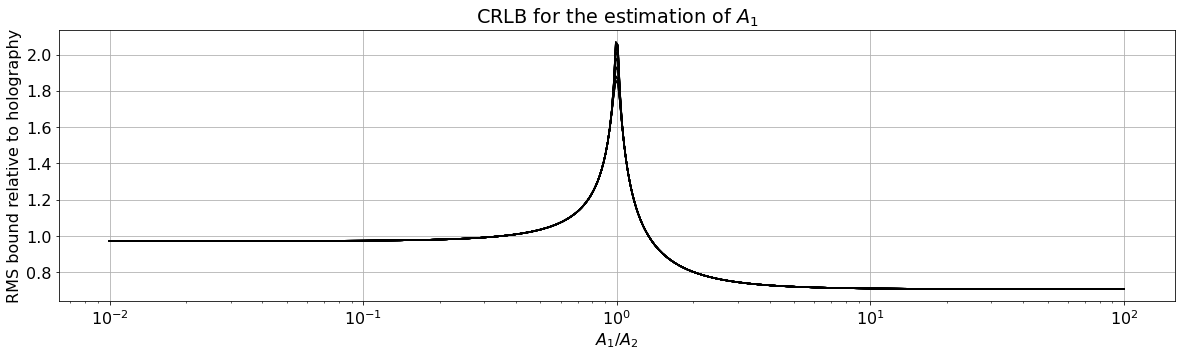

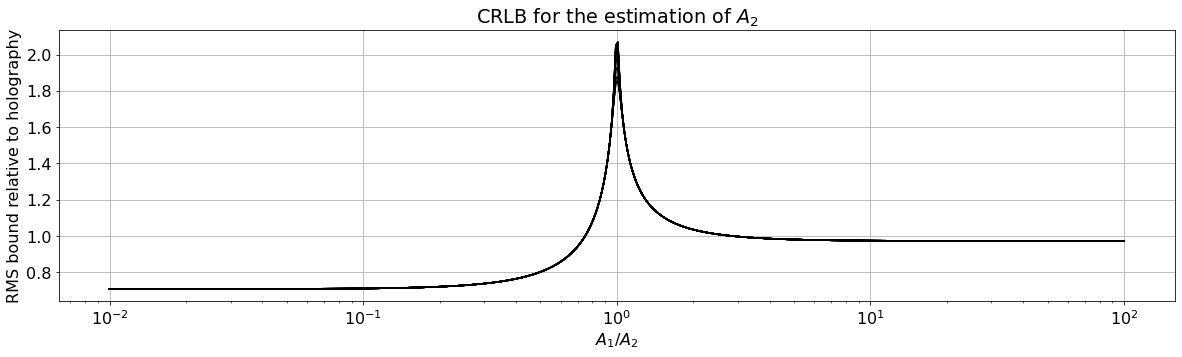

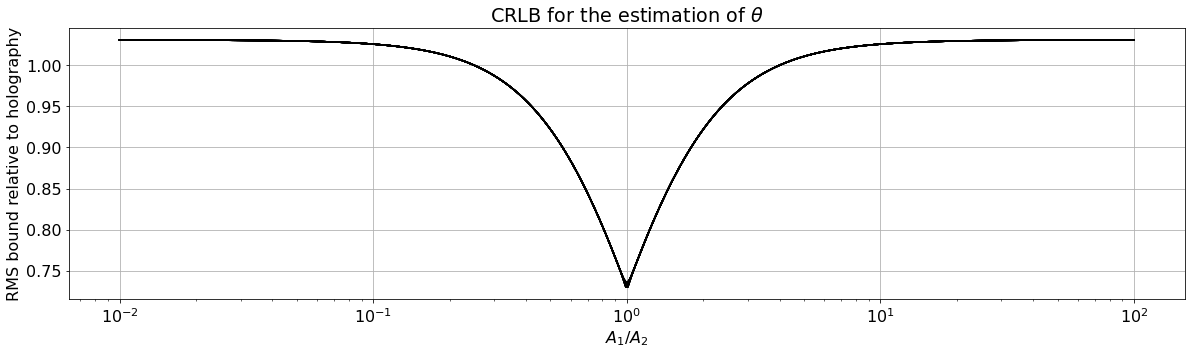

In [ ]:
#
# Specify the sampling matrix here:
#
#
# Specify the sampling matrix here:
#
Mp=100;
a=Mp/40;
Hp=a*np.complex64([[1,0],[0,1]]);
for pop in range(Mp):
  hl=[[np.cos(np.pi/4.), np.exp(1j*2*np.pi*pop/Mp)*np.sin(np.pi/4.)],\
        [ -np.exp(1j*2*np.pi*pop/Mp)*np.sin(np.pi/4.), np.cos(np.pi/4)]];
  Hp=np.vstack((Hp,hl))
H=Hp/np.sqrt(np.sum(np.power(np.abs(Hp),2),0))
#
# parameter values
#
abar         = 1
rho          = np.logspace(-2, 2, 500)
theta        = np.linspace(-math.pi, math.pi, 20)
[Rho, Theta] = np.meshgrid(rho, theta)
# 
# evaluate CRLBs
#
CRLB = twoPointPhaseRetrievalCRLB(abar*np.sqrt(Rho), \
                                  abar/np.sqrt(Rho), \
                                  Theta, H)
#
# plot the results
#
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [20,5]
plt.figure(1)
_ = plt.semilogx(rho, np.sqrt(CRLB.A1/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $A_1$')
plt.figure(2)
_ = plt.semilogx(rho, np.sqrt(CRLB.A2/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $A_2$')
plt.figure(3)
_ = plt.semilogx(rho, np.sqrt(CRLB.theta/((Rho + 1/Rho)/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $\theta$')

## Cramer-Rao Bound for amplitudes
We may also represent the two modes are represented using real numbers $a$ and $b+ic$. We may assume that the first mode ampitude $a$ is nonnegative. The modes are transformed by the $M \times 2$ linear sampling matrix ${\bf H}$ to provide the intermediate signal $\underline{y}$:

\begin{equation}
\underline{y} = {\bf H}
\left[
  \begin{array}{c}
 a\\ b+ic
  \end{array}
\right].
\end{equation}

To assure that the sampling is passive, both of the eigenvalues for ${\bf H}^\dagger {\bf H}$ must be less than or equal to 1. The observable signal, then, is the intensity for $\underline{y}$:

\begin{equation}
I_m = |y_m|^2.
\end{equation}

When the observed data are limited by photon noise, the Fisher information for the unobserved parameters is evaluated as
\begin{equation}
J_{\lambda, \gamma} = \sum_{m=1}^M 
\frac{\partial I_m}{\partial \lambda}
\frac{\partial I_m}{\partial \gamma}
\frac{1}{I_m}
\end{equation}
where $\lambda$ and $\gamma$ correspond to pairs of the parameters $(a,b,c)$. For example, the Fisher information for $a$ and $c$ is
\begin{equation}
J_{A_1, \theta} = \sum_{m=1}^M 
\frac{\partial I_m}{\partial a}
\frac{\partial I_m}{\partial c}
\frac{1}{I_m}
\end{equation}
The Fisher-information matrix is
\begin{equation}
{\bf J} = 
\left[
  \begin{array}{ccc}
  J_{aa} & J_{ab} & J_{ac} \\
  J_{ba} & J_{bb} & J_{bc} \\
  J_{ca} & J_{cb} & J_{cc}
  \end{array}
\right],
\end{equation}  
and the Cramer-Rao lower bound matrix is
\begin{equation}
{\bf C} = {\bf J}^{-1}.
\end{equation}

In [ ]:

# Version: 2020_10_12 djb

def twoPointPhaseRetrievalCRLBx(a, b, c, H):
#
# twoPointPhaseRetrievalCRLB:
#   Python function to evaluate the Cramer-Rao Lower Bound for the
#   phase-retrieval problem with a specific observation matrix H.
#
# Usage:
#   CRLB = twoPointPhaseRetrievalCRLB(A1, A2, theta, H);
#
# Inputs:
#      A1: KxN array of amplitudes for the first element in the signal
#      A2: KxN array of amplitudes for the second element in the signal
#   theta: KxN array of phases for the signal
#       H: Mx2 observation matrix 
#
# Outputs:
#      CRLB.A1: KxN array of the CRLB for the amplitudes specified in A1
#      CRLB.A2: KxN array of the CRLB for the amplitudes specified in A2
#   CRLB.theta: KxN array of the CRLB for the phases specified in theta
#
  # verify that the sampling system is passive
  (w, v) = la.eig(H.conjugate().T.dot(H))
  if w.real.max() > 1.0001:
    print('Sampling systems is not passive!')
    return -1


  # determine the number of samples
  M    = H.shape[0]

  # initialize the Fisher information elements
  # (because of symmetry, J12 = J21, etc.)
  J11 = np.zeros(np.shape(a))
  J12 = np.zeros(np.shape(a))
  J13 = np.zeros(np.shape(a))
  J22 = np.zeros(np.shape(a))
  J23 = np.zeros(np.shape(a))
  J33 = np.zeros(np.shape(a))  

  # evaluate the Fisher information elements
  for m in range(0,M):
    I    = np.abs(H[m,0]*a+H[m,1]*(b+1j*c))**2
    dIk1 = 2*a*np.abs(H[m,0])**2+2*b*np.real(H[m,0]*np.conjugate(H[m,1]))+2*c*np.imag(H[m,0]*np.conjugate(H[m,1]))
    dIk2 = 2*b*np.abs(H[m,1])**2+2*a*np.real(H[m,0]*np.conjugate(H[m,1]))
    dIk3 = 2*c*np.abs(H[m,1])**2+2*a*np.imag(H[m,0]*np.conjugate(H[m,1]))
    J11  = J11 + dIk1*dIk1/I
    J12  = J12 + dIk1*dIk2/I
    J13  = J13 + dIk1*dIk3/I
    J22  = J22 + dIk2*dIk2/I
    J23  = J23 + dIk2*dIk3/I
    J33  = J33 + dIk3*dIk3/I
    
  
  # determine the CRLB elements for the parameters
  detJ = -(np.power(J13,2)*J22) + 2*J12*J13*J23 - \
         J11*np.power(J23,2) - np.power(J12,2)*J33 + J11*J22*J33
  class CRLB:
    a   = (-np.power(J23,2) + J22*J33)/detJ         
    b    = (-np.power(J13,2) + J11*J33)/detJ 
    c = (-np.power(J12,2) + J11*J22)/detJ
  return CRLB


# 6 measurements

Text(0.5, 1.0, 'CRLB for the estimation of $c$')

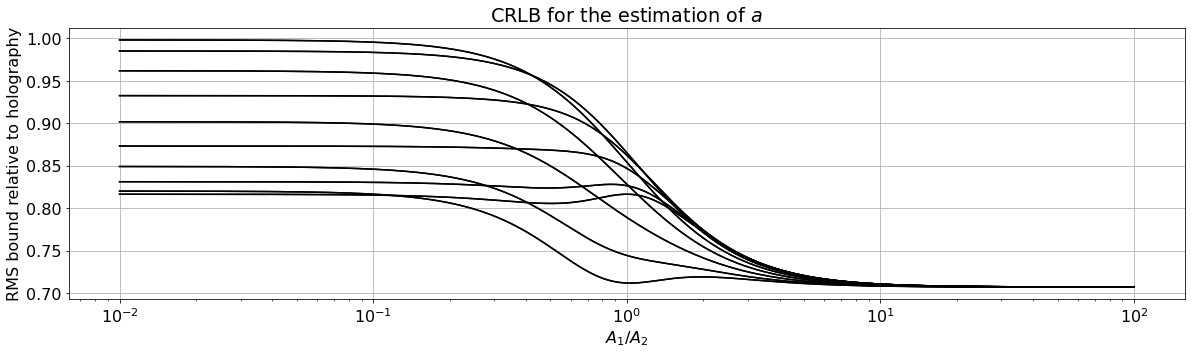

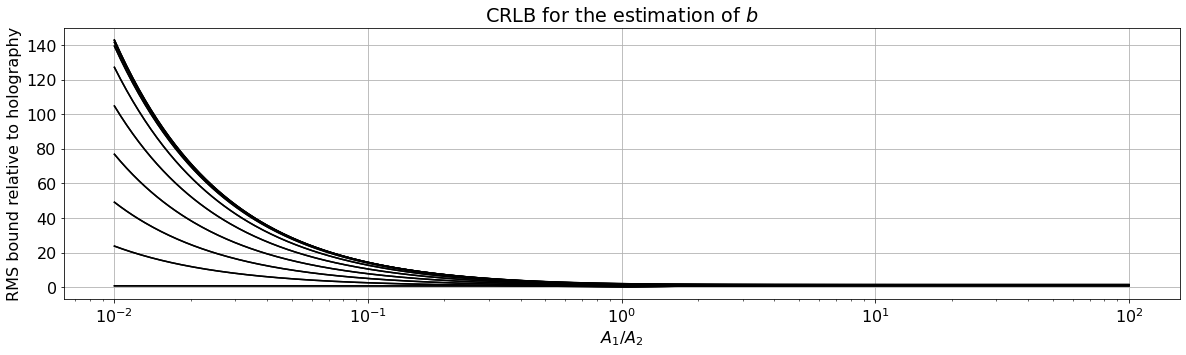

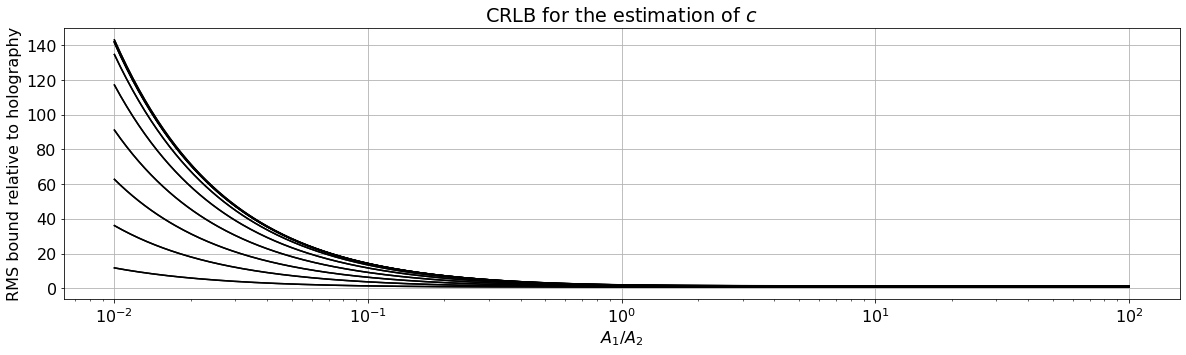

In [ ]:
#
# sampling matrix
#
intenR=.5; # ratio of signal in pure intensity measurement
iSam=np.sqrt(1-intenR);
pSam=np.sqrt(intenR)/2;
H=np.array([[iSam,0], [0, iSam],[pSam, pSam],[pSam, -pSam],[pSam, 1j*pSam],[pSam, -1j*pSam]] )
#
# parameter values
#
abar         = 1
rho          = np.logspace(-2, 2, 500)
theta        = np.linspace(-math.pi, math.pi, 20)
[Rho, Theta] = np.meshgrid(rho, theta)
# 
# evaluate CRLBs
#
CRLB = twoPointPhaseRetrievalCRLBx(abar*np.sqrt(Rho), \
                                  (abar/np.sqrt(Rho))*np.cos(Theta), \
                                  (abar/np.sqrt(Rho))*np.sin(Theta), H)
matrix
#
# plot the results
#(abar/np.sqrt(Rho))*np.cos(Theta)
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [20,5]
plt.figure(1)
_ = plt.semilogx(rho, np.sqrt(CRLB.a/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $a$')
plt.figure(2)
_ = plt.semilogx(rho, np.sqrt(CRLB.b/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $b$')
plt.figure(3)
_ = plt.semilogx(rho, np.sqrt(CRLB.c/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $c$')

Text(0.5, 1.0, 'CRLB for the estimation of $c$')

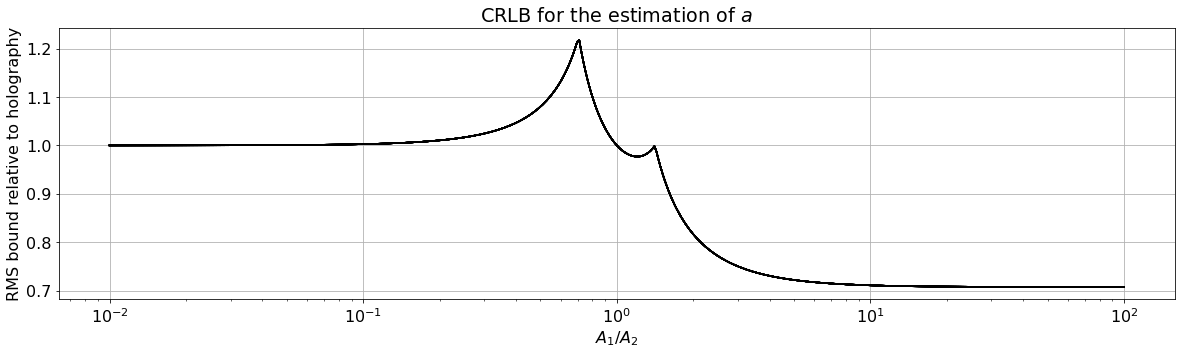

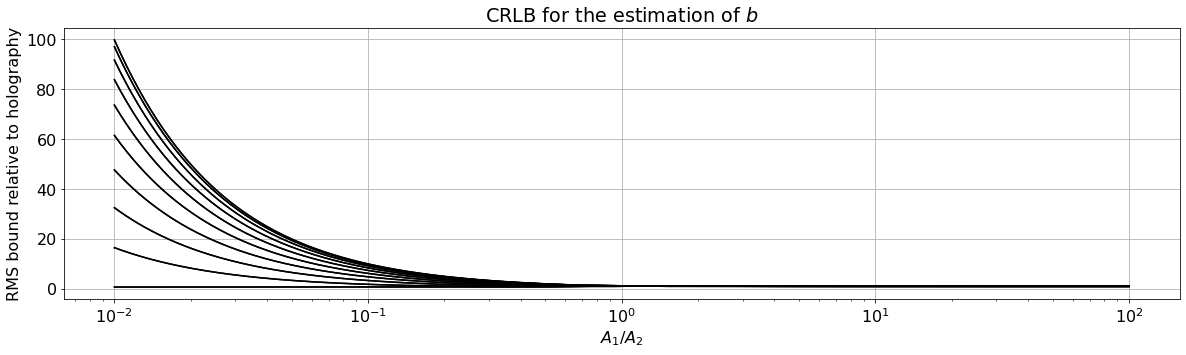

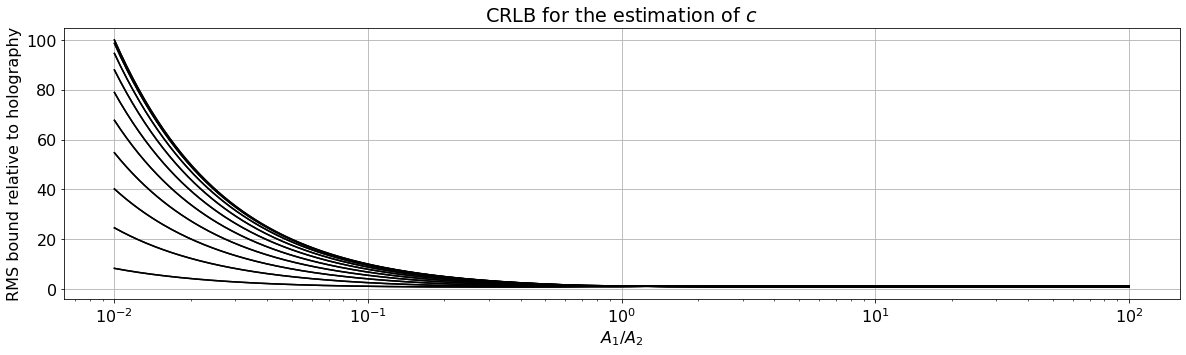

In [ ]:
#
# sampling matrix
#
M     = 1000;
m     = np.arange(0,M)
f1    = 0; f2 = f1 + 1;
h1    = np.sqrt(2/3)*np.exp(-1j*2*np.pi*f1*m/M)/np.sqrt(M)
h2    = np.sqrt(1/3)*np.exp(-1j*2*np.pi*f2*m/M)/np.sqrt(M)
H     = np.column_stack((h1, h2))
M     = 1000;
m     = np.arange(0,M)
f1    = 0; f2 = f1 + 1;
h1    = np.sqrt(1/3)*np.exp(-1j*2*np.pi*f1*m/M)/np.sqrt(M)
h2    = np.sqrt(2/3)*np.exp(-1j*2*np.pi*f2*m/M)/np.sqrt(M)
H1     = np.column_stack((h1, h2))
H     = np.row_stack((H, H1))
#
# parameter values
#
abar         = 1
rho          = np.logspace(-2, 2, 500)
theta        = np.linspace(-math.pi, math.pi, 20)
[Rho, Theta] = np.meshgrid(rho, theta)

# 
# evaluate CRLBs
#
CRLB = twoPointPhaseRetrievalCRLBx(abar*np.sqrt(Rho), \
                                  (abar/np.sqrt(Rho))*np.cos(Theta), \
                                  (abar/np.sqrt(Rho))*np.sin(Theta), H)

#
# plot the results
#(abar/np.sqrt(Rho))*np.cos(Theta)
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [20,5]
plt.figure(1)
_ = plt.semilogx(rho, np.sqrt(CRLB.a/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $a$')
plt.figure(2)# 
# evaluate CRLBs
#
CRLB = twoPointPhaseRetrievalCRLBx(abar*np.sqrt(Rho), \
                                  (abar/np.sqrt(Rho))*np.cos(Theta), \
                                  (abar/np.sqrt(Rho))*np.sin(Theta), H)
…plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $c$')
_ = plt.semilogx(rho, np.sqrt(CRLB.b/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$') 
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $b$')
plt.figure(3)
_ = plt.semilogx(rho, np.sqrt(CRLB.c/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$A_1/A_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $c$')

## Cramer-Rao Bound for phase with known amplitude
Here we assume the two modes are represented as $A$ and $A e^{j \theta}$, where $\theta$ is the phase h1    = np.exp(-1j*2*np.pi*f1*m/M)/np.sqrt(M)
h2    = np.exp(-1j*2*np.pi*f2*m/M)/np.sqrt(M)
H     = np.column_stack((h1, h2))difference between the modes. The modes are transformed by the $M \times 2$ linear sampling matrix ${\bf H}$ to provide the intermediate signal $\underline{y}$:

\begin{equation}
\underline{y} = {\bf H}
\left[
  \begin{array}{c}
  A \\ A^{j\theta}
  \end{array}
\right].
\end{equation}

 The observable signal is the intensity for $\underline{y}$:

\begin{equation}
I_m = |y_m|^2.
\end{equation}

Since $\theta$ is the only unknown parameter, the Fisher information is simply
\begin{equation}
J = \sum_{m=1}^M 
\frac{1}{I_m}\left \lbrack\frac{\partial I_m}{\partial \theta}\right \rbrack^2
\end{equation}
where $\lambda$ and $\gamma$ correspond to pairs of the parameters $(A_1, A_2, \theta)$. 
and the Cramer-Rao lower bound is
\begin{equation}
{\bf C} = {\bf J}^{-1}.
\end{equation}

If, for example,
\begin{equation}
{\bf H}= 
\frac{1}{2\sqrt{2}}\left[
  \begin{array}{cc}
  1 & 1\\
  1&-1 \\
  \end{array}
\right].
\end{equation}
then $J=|A|^2$ and the CRLB is  $1/|A|^2$, which matches holography. Results above suggest that somewhat better results may be obtained for example by the Fourier sampling method. 

If, as in the Fourier method described above, we take $M$ measurements with
$$h_1= \frac{1}{2\sqrt{M}}$$
and
$$h_2= \frac{1}{2\sqrt{M}}e^{-2\pi i \frac{ m}{M}}$$
then 
$$I_m=\frac{|A|^2}{M}\left (1+ \cos \left (\theta - 2\pi \frac{ m}{M}\right )\right )$$
and
$$\frac{\partial I_m}{\partial \theta}=-\frac{|A|^2}{M}\sin \left (\theta - 2\pi \frac{ m}{M}\right )$$
so
$$
\begin{array}{ll}
\frac{1}{I_m}\left \lbrack\frac{\partial I_m}{\partial \theta}\right \rbrack^2&=\frac{|A|^2}{M}\frac{\sin^2 \left (\theta - 2\pi \frac{ m}{M}\right )}
{\left (1+ \cos \left (\theta - 2\pi \frac{ m}{M}\right )\right )}\\
&=\frac{|A|^2}{M}\left (1- \cos \left (\theta - 2\pi \frac{ m}{M}\right )\right )
\end{array}
$$
so that once again $J=|A|^2$. 

